### Construct Dataset with Lag Features and Target

In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [10]:
# Define the ticker symbol and date range
ticker_symbol = "MSFT"
start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')  # Format today's date as a string

# Download historical data for the ticker
df = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [11]:

# Calculate technical indicators
# MACD
df['macd'], df['macdSignal'], df['macdHist'] = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# RSI
df['rsi'] = ta.RSI(df['Close'], timeperiod=14)
# Bollinger Bands
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
# Simple Moving Averages
df['sma200'] = ta.SMA(df['Close'], timeperiod=200)
df['sma100'] = ta.SMA(df['Close'], timeperiod=50)
df['sma50'] = ta.SMA(df['Close'], timeperiod=50)
# Exponential Moving Averages
df['ema12'] = ta.EMA(df['Close'], timeperiod=12)
df['ema26'] = ta.EMA(df['Close'], timeperiod=26)
df['ema50'] = ta.EMA(df['Close'], timeperiod=26)
# Stochastic Oscillator
df['slowk'], df['slowd'] = ta.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
# Volume
df['volume'] = df['Volume']
# Average True Range
df['atr'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
# Average Directional Movement Index
df['adx'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
#additonal technical indicators
df['parabolic_sar'] = ta.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
df['williams_r'] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)


In [12]:

# # Create lagging features for the last 30 days
# intervals = [1, 3, 7, 15, 30]
# for col in ['macd', 'rsi', 'upper_band', 'middle_band', 'lower_band', 'sma200', 'sma50', 'ema12', 'ema26', 'slowk', 'slowd', 'volume', 'atr', 'adx']:
#     for interval in intervals:
#         df[f'{col}_lag{interval}'] = df[col].shift(interval)


In [ ]:
# Add more lag intervals
extended_intervals = [1, 3, 7, 14, 21, 30, 45, 60]

# Rolling statistics
rolling_windows = [7, 14, 21, 30]
for window in rolling_windows:
    df[f'close_rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'close_rolling_std_{window}'] = df['Close'].rolling(window=window).std()

# Rate of Change for Close prices
df['close_roc'] = df['Close'].pct_change(periods=1)

# Additional technical indicators
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)

# Creating lag features for all
features_to_lag = ['macd', 'rsi', 'upper_band', 'middle_band', 'lower_band', 
                   'sma200', 'sma50', 'ema12', 'ema26', 'slowk', 'slowd', 
                   'volume', 'atr', 'adx', 'close_roc', 'cci'] + [f'close_rolling_mean_{window}' for window in rolling_windows] + [f'close_rolling_std_{window}' for window in rolling_windows]

for col in features_to_lag:
    for interval in extended_intervals:
        df[f'{col}_lag{interval}'] = df[col].shift(interval)

In [13]:

# Construct the target column
df['pct_change'] = df['Close'].pct_change(periods=5)
conditions = [
    (df['pct_change'] >= 0.02),
    (df['pct_change'] <= -0.02)
]
choices = [0, 1]
df['target'] = np.select(conditions, choices, default=2)
df.drop(columns=['pct_change'], inplace=True)


In [14]:

# Clean the DataFrame by dropping NaN values and the 'Date' index if it exists
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)


In [15]:

# The final DataFrame is ready for use
df.head()


,Open,High,Low,Close,Adj Close,Volume,macd,macdSignal,macdHist,rsi,...,atr_lag3,atr_lag7,atr_lag15,atr_lag30,adx_lag1,adx_lag3,adx_lag7,adx_lag15,adx_lag30,target
229,25.049999,25.469999,25.000000,25.260000,19.558207,75282100,-0.153259,0.012617,-0.165876,40.949985,...,0.513912,0.558163,0.637536,0.447608,25.522146,28.958524,36.139224,38.975304,20.049474,2
230,25.570000,26.250000,25.559999,26.040001,20.162142,74123500,-0.108276,-0.011562,-0.096714,53.767817,...,0.494347,0.535437,0.620569,0.477779,24.001878,27.020322,34.865377,40.506224,20.470331,0
231,26.240000,26.980000,26.200001,26.889999,20.820274,91759200,-0.003993,-0.010048,0.006055,63.154065,...,0.494036,0.518620,0.595529,0.465081,23.642130,25.522146,33.293673,41.927792,20.910833,0
232,26.809999,27.059999,26.780001,27.020000,20.920933,52622000,0.088127,0.009587,0.078540,64.346310,...,0.492319,0.527290,0.600134,0.466861,24.368740,24.001878,31.045818,41.846304,21.556183,0
233,26.930000,26.980000,26.760000,26.840000,20.781561,36264200,0.144937,0.036657,0.108280,61.384575,...,0.527868,0.513912,0.598696,0.452799,25.143526,23.642130,28.958524,41.340002,22.155437,0


In [26]:
# Assuming 'df' is your DataFrame and 'target' is your target column
unique_target_counts = df['target'].value_counts()
print(unique_target_counts)


target
2    1723
0     953
1     621
Name: count, dtype: int64


In [22]:

# Assume df is your cleaned DataFrame from previous steps
features = df.drop('target', axis=1)  # Exclude the target variable
targets = df['target']  # Only the target variable

# Perform a train-validation-test split (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(features, targets, test_size=0.30, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test data (do not fit on validation/test data to prevent data leakage)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled, X_val_scaled, and X_test_scaled have scaled features
# y_train, y_val, and y_test remain unchanged as the target variables


### Training

In [49]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight


In [75]:
#Class Balancing
#TODO: decide whether want to balance completely, or weight buy, sell, hold differently

#manual class balancing
custom_class_weights = {0: 1.0, 1: 1.5, 2: 1}

# Assuming X_train_scaled, y_train, X_val_scaled, y_val are your data

# Calculate class weights for training set
class_weights = compute_class_weight(class_weight=custom_class_weights, classes=np.unique(y_train), y=y_train)

# Assign weights to each sample in the training set
sample_weights = np.array([class_weights[i] for i in y_train])


In [76]:

# Initialize the XGBoost classifier for multi-class classification
model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', num_class=3, use_label_encoder=False)

# Fit the model on the training data with sample weights
model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Predict on the validation set
val_predictions = model.predict(X_val_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {accuracy}")

# Additional metrics like F1-score can be calculated as needed


Validation Accuracy: 0.7737373737373737


### Pre Hyperparameter Evaluation and Visualizations

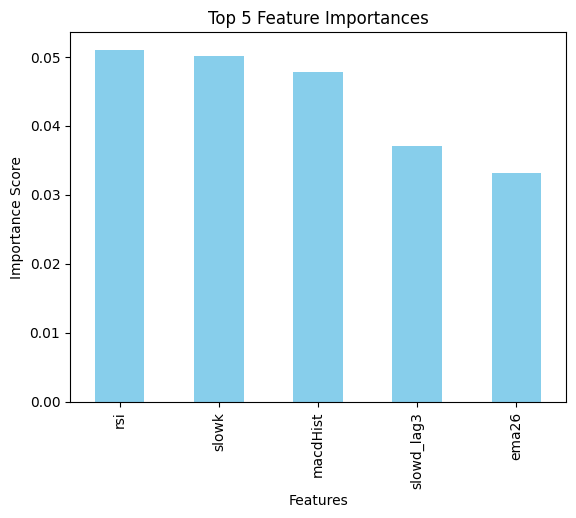

In [77]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained XGBoost model
# and 'features' contains the feature column names

# Get feature importances
feature_importances = model.feature_importances_

# Create a Series for the feature importances
importances = pd.Series(feature_importances, index=features.columns)

# Sort the features by their importance
sorted_importances = importances.sort_values(ascending=False)

# Select the top 5 features
top_5_importances = sorted_importances[:5]

# Plot
top_5_importances.plot(kind='bar', color='skyblue')
plt.title('Top 5 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()


Validation Accuracy: 0.7737373737373737
Validation Precision: 0.7753876720574975
Validation Recall: 0.7737373737373737
Validation F1 Score: 0.7734718730797163


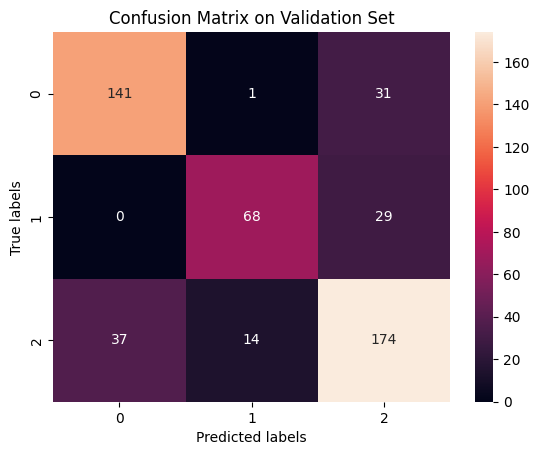

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming val_predictions are the predictions from your model on the validation set
# and y_val are the true target values

# Calculate evaluation metrics for the validation set
accuracy_val = accuracy_score(y_val, val_predictions)
precision_val = precision_score(y_val, val_predictions, average='weighted')  # Use 'weighted' for imbalanced classes
recall_val = recall_score(y_val, val_predictions, average='weighted')
f1_val = f1_score(y_val, val_predictions, average='weighted')

# Display the metrics
print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")

# Confusion matrix for validation set
conf_matrix_val = confusion_matrix(y_val, val_predictions)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_val, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()


### Hyperparameter Optimization

In [97]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import time


# Define your XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, use_label_encoder=False)

# Define the parameter grid
param_grid = {
    'learning_rate': [.3, .4, .5],
    'n_estimators': [300],
    'max_depth': [3, 4, 5],
    'subsample': [.5, .6, .7],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'gamma': [0, 0.5, 1]
}

## More thorough hyperparameter search
# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
#     'n_estimators': [50, 100, 150, 200, 250, 300],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
#     'gamma': [0, 0.05, 0.1, 0.15, 0.2],
#     'min_child_weight': [1, 2, 3, 4, 5],
#     'reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],  # L1 regularization term
#     'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 2]  # L2 regularization term
# }

# Record start time
start_time = time.time()

# Execute the hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Record end time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

# Print the execution time
print(f"Hyperparameter tuning took {execution_time:.2f} seconds")

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_predictions = best_model.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Hyperparameter tuning took 81.09 seconds
Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}
Best Score: 0.706111833550065
Validation Accuracy: 0.7676767676767676


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}

Test Accuracy: 0.7757575757575758
Test Precision: 0.7826381734606289
Test Recall: 0.7757575757575758
Test F1 Score: 0.7773513705254897


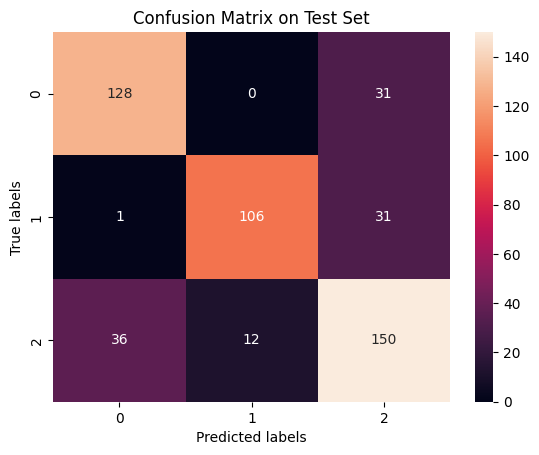

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming best_grid is your trained model
# X_test_scaled is your scaled test features, and y_test are the true labels

# Generate predictions on the test set
test_predictions = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_test, test_predictions, average='weighted')
f1 = f1_score(y_test, test_predictions, average='weighted')

# Display the metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions)

# Visualize the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Test Set')
plt.show()


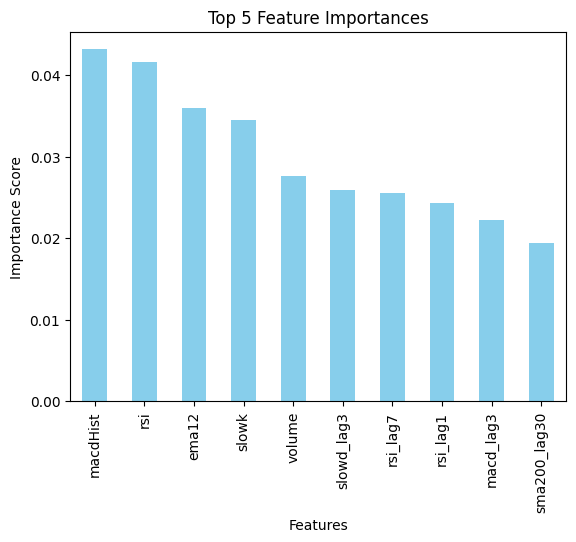

In [100]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained XGBoost model
# and 'features' contains the feature column names

# Get feature importances
feature_importances = best_model.feature_importances_

# Create a Series for the feature importances
importances = pd.Series(feature_importances, index=features.columns)

# Sort the features by their importance
sorted_importances = importances.sort_values(ascending=False)

# Select the top 5 features
top_5_importances = sorted_importances[:10]

# Plot
top_5_importances.plot(kind='bar', color='skyblue')
plt.title('Top 5 Feature Importances')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()


### Save Dataset and Model

In [101]:
import pickle
from joblib import dump, load
import pandas as pd
from datetime import datetime

# Assuming 'best_model' is your trained model
# 'features' and 'targets' are your datasets

# Generate a unique filename using the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'custom_balanced_model_{current_time}.joblib'

# Save the model using joblib
dump(best_model, model_filename)

# Save the features and targets datasets using pandas
features.to_csv('features.csv', index=False)
targets.to_csv('targets.csv', index=False)


In [102]:

# Load the model
loaded_model = load(model_filename)

# Load the datasets
loaded_features = pd.read_csv('features.csv')
loaded_targets = pd.read_csv('targets.csv')


In [103]:
print(type(test_predictions))
print(test_predictions.shape)

<class 'numpy.ndarray'>
(495,)


### Calculate Returns using Model Signals

In [104]:
#TODO: calculate returns using model signals and benchmark it against other stategy(MACD + SMA?)

In [105]:
# Extract the test set portion from the original DataFrame
test_df = df.loc[X_test.index]


In [106]:
# Assuming test_df is your DataFrame with 'Close' and 'Predictions'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold


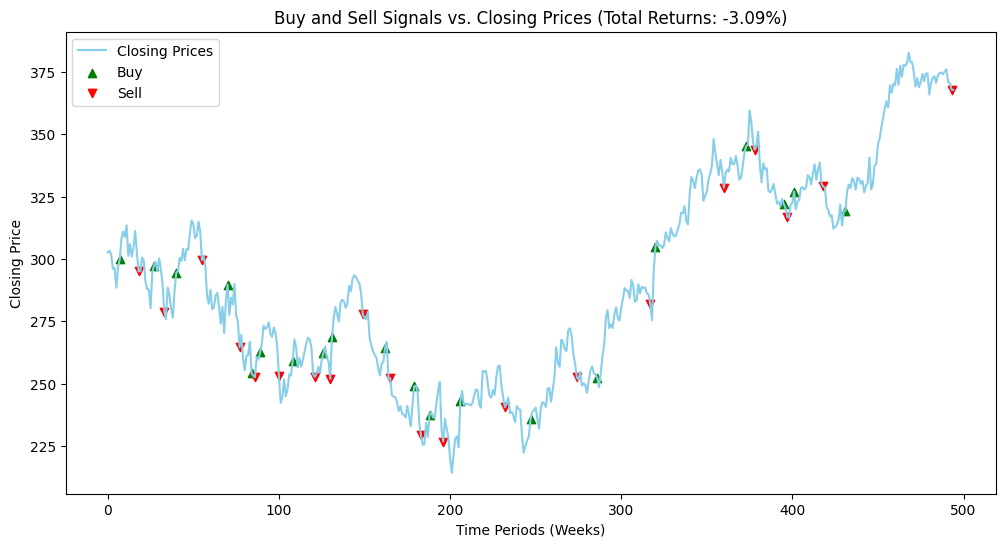

In [107]:
import matplotlib.pyplot as plt

def calculate_return_of_strategy_weekly(close_list, signal_list):
    trade_list = []
    position = 'none'
    buy_price = 0
    buy_sell_points = {'buy': [], 'sell': []}  # To keep track of buy and sell points for plotting

    for i in range(len(close_list)):
        if signal_list[i] == 0 and position == 'none':  # Buy signal
            buy_price = close_list[i]
            position = 'bought'
            trade_list.append(('buy', buy_price))
            buy_sell_points['buy'].append((i, buy_price))  # Record buy point

        elif signal_list[i] == 1 and position == 'bought':  # Sell signal
            sell_price = close_list[i]
            position = 'none'
            trade_list.append(('sell', sell_price))
            buy_sell_points['sell'].append((i, sell_price))  # Record sell point

    total_return = 1
    for i in range(0, len(trade_list), 2):
        if i + 1 < len(trade_list):
            total_return *= (trade_list[i + 1][1] / trade_list[i][1])

    return 100 * (total_return - 1), buy_sell_points

# Assuming test_df is your DataFrame with 'Close' and 'Predictions'
close_prices_test = test_df['Close'].tolist()
model_predictions_test = test_predictions.tolist()  # 0 for buy, 1 for sell, 2 for hold

# Calculate returns and get buy/sell points
returns, buy_sell_points = calculate_return_of_strategy_weekly(close_prices_test, model_predictions_test)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(close_prices_test, label='Closing Prices', color='skyblue')

# Plot buy and sell signals
for buy_point in buy_sell_points['buy']:
    plt.scatter(buy_point[0], buy_point[1], color='green', marker='^', label='Buy' if buy_point == buy_sell_points['buy'][0] else "")

for sell_point in buy_sell_points['sell']:
    plt.scatter(sell_point[0], sell_point[1], color='red', marker='v', label='Sell' if sell_point == buy_sell_points['sell'][0] else "")

plt.title(f"Buy and Sell Signals vs. Closing Prices (Total Returns: {returns:.2f}%)")
plt.xlabel('Time Periods (Weeks)')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

#rn it holds too much when it should sell
#best model so far was the original one(reverted the hyperparameters), it just doesn't perform well on converged markets

In [ ]:
#TODO: add rule based strategies and risk mitigation strategies

In [ ]:
#Additional TODO: class balance using xgboost.DMatrix?, add more features, add more tickers(as a parameter), further backtrading, parameterize uptrend-downtrend definitions